In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from datetime import date, datetime
import warnings
warnings.filterwarnings('ignore')

In [19]:
def get_weather_forecast(dates, location="Rust, Germany"):
    """Get weather forecast for future dates using free API."""
    import requests
    from datetime import datetime
    
    weather_data = []
    
    print(f"Fetching weather for {location}...")
    
    for date_obj in dates:
        try:
            date_str = date_obj.strftime("%Y-%m-%d")
            
            url = f"https://wttr.in/{location.replace(' ', '+')}?format=j1&date={date_str}"
            
            response = requests.get(url, timeout=10)
            
            if response.status_code == 200:
                data = response.json()
                
                if 'weather' in data and len(data['weather']) > 0:
                    day_weather = data['weather'][0]
                    
                    temp_c = float(day_weather.get('avgtempC', 20))
                    
                    precip_mm = float(day_weather.get('totalSnow_cm', 0)) + float(day_weather.get('precipMM', 0))
                    
                    wind_kmh = float(day_weather.get('uvIndex', 10))
                    if 'hourly' in day_weather and len(day_weather['hourly']) > 0:
                        wind_kmh = float(day_weather['hourly'][0].get('windspeedKmph', 10))
                    
                    weather_data.append({
                        'date': pd.to_datetime(date_obj),
                        'temperature': temp_c,
                        'rain': precip_mm,
                        'wind': wind_kmh
                    })
                    
                    print(f"  {date_str}: {temp_c}°C, {precip_mm}mm rain, {wind_kmh}km/h wind")
                
                else:
                    weather_data.append({
                        'date': pd.to_datetime(date_obj),
                        'temperature': 20,
                        'rain': 0,
                        'wind': 10
                    })
                    print(f"  {date_str}: Using defaults (API data incomplete)")
            
            else:
                weather_data.append({
                    'date': pd.to_datetime(date_obj),
                    'temperature': 20,
                    'rain': 0,
                    'wind': 10
                })
                print(f"  {date_str}: API error, using defaults")
        
        except Exception as e:
            weather_data.append({
                'date': pd.to_datetime(date_obj),
                'temperature': 20,
                'rain': 0, 
                'wind': 10
            })
            print(f"  {date_str}: Error ({e}), using defaults")
    
    return pd.DataFrame(weather_data)

In [20]:
def load_and_split_data(file_path, test_year=2023):
    """Load data and split by year to avoid data leaks."""
    df = pd.read_parquet(file_path)
    
    print(f"Loaded data with shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    
    # Extract ride names from one-hot encoded columns
    ride_name_cols = [col for col in df.columns if col.startswith('ride_name_') and not any(x in col for x in ['sin', 'cos'])]
    if ride_name_cols:
        df['ride_name'] = df[ride_name_cols].idxmax(axis=1).str.replace('ride_name_', '')
    else:
        print("Warning: No ride_name columns found")
        df['ride_name'] = 'unknown'
    
    # Extract year from one-hot encoded columns
    year_cols = [col for col in df.columns if col.startswith('year_') and col.replace('year_', '').isdigit()]
    if year_cols:
        df['year'] = df[year_cols].idxmax(axis=1).str.replace('year_', '').astype(int)
    else:
        print("Warning: No year columns found")
        if 'timestamp' in df.columns:
            df['year'] = pd.to_datetime(df['timestamp']).dt.year
        else:
            df['year'] = 2022
    
    # Extract month from one-hot encoded columns (only numeric months, not month_sin/cos)
    month_cols = [col for col in df.columns if col.startswith('month_') and 
                  col.replace('month_', '').isdigit()]
    if month_cols:
        df['month'] = df[month_cols].idxmax(axis=1).str.replace('month_', '').astype(int)
    else:
        print("Warning: No month columns found")
        if 'timestamp' in df.columns:
            df['month'] = pd.to_datetime(df['timestamp']).dt.month
        else:
            df['month'] = 6
    
    # Extract day from one-hot encoded columns (only numeric days)
    day_cols = [col for col in df.columns if col.startswith('day_') and 
                col.replace('day_', '').isdigit()]
    if day_cols:
        df['day'] = df[day_cols].idxmax(axis=1).str.replace('day_', '').astype(int)
    else:
        print("Warning: No day columns found")
        if 'timestamp' in df.columns:
            df['day'] = pd.to_datetime(df['timestamp']).dt.day
        else:
            df['day'] = 15
    
    # Extract hour from one-hot encoded columns (only numeric hours)
    hour_cols = [col for col in df.columns if col.startswith('hour_') and 
                 col.replace('hour_', '').isdigit()]
    if hour_cols:
        df['hour'] = df[hour_cols].idxmax(axis=1).str.replace('hour_', '').astype(int)
    else:
        print("Warning: No hour columns found")
        if 'timestamp' in df.columns:
            df['hour'] = pd.to_datetime(df['timestamp']).dt.hour
        else:
            df['hour'] = 12
    
    # Create date column
    try:
        df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
    except Exception as e:
        print(f"Error creating date column: {e}")
        print(f"Year range: {df['year'].min()}-{df['year'].max()}")
        print(f"Month range: {df['month'].min()}-{df['month'].max()}")
        print(f"Day range: {df['day'].min()}-{df['day'].max()}")
        # Fix invalid dates
        df['month'] = df['month'].clip(1, 12)
        df['day'] = df['day'].clip(1, 28)
        df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
    
    # Create full timestamp
    try:
        df['timestamp'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
    except Exception as e:
        print(f"Error creating timestamp column: {e}")
        df['hour'] = df['hour'].clip(0, 23)
        df['timestamp'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
    
    # Filter out COVID period (2020-2021)
    print(f"Data years available: {sorted(df['year'].unique())}")
    covid_mask = (df['year'] >= 2020) & (df['year'] <= 2021)
    covid_data_count = covid_mask.sum()
    
    if covid_data_count > 0:
        print(f"⚠️  Filtering out {covid_data_count} COVID-period records (2020-2021)")
        df = df[~covid_mask]
    
    # Filter to reasonable operating hours (remove very early/late hours)
    reasonable_hours = (df['hour'] >= 9) & (df['hour'] <= 21)
    before_filter = len(df)
    df = df[reasonable_hours]
    print(f"Filtered to operating hours (9-21): {len(df)} records (removed {before_filter - len(df)})")
    
    # Add day_of_week if not present
    if 'day_of_week' not in df.columns:
        df['day_of_week'] = df['timestamp'].dt.dayofweek
    
    # Split data by year
    train_mask = df['year'] < test_year
    test_mask = df['year'] == test_year
    
    train_data = df[train_mask].copy()
    test_data = df[test_mask].copy()
    
    print(f"Train data: {len(train_data)} samples")
    print(f"Test data: {len(test_data)} samples")
    
    if len(train_data) > 0:
        print(f"Date range - Train: {train_data['date'].min()} to {train_data['date'].max()}")
    if len(test_data) > 0:
        print(f"Date range - Test: {test_data['date'].min()} to {test_data['date'].max()}")
    
    return train_data, test_data

In [21]:
def check_data_quality(df):
    """Check for data quality issues."""
    print("=== Data Quality Check ===")
    print(f"Total records: {len(df)}")
    print(f"Date range: {df['date'].min()} to {df['date'].max()}")
    print(f"Unique dates: {df['date'].nunique()}")
    print(f"Hours per day (avg): {len(df) / df['date'].nunique():.1f}")
    
    # Check for missing days of week
    dow_counts = df['day_of_week'].value_counts().sort_index()
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    print("\nRecords by day of week:")
    for i, day in enumerate(days):
        count = dow_counts.get(i, 0)
        print(f"  {day}: {count} records")
    
    # Check hour distribution
    hour_counts = df['hour'].value_counts().sort_index()
    print(f"\nHour range: {df['hour'].min()}-{df['hour'].max()}")
    print(f"Hours with <100 records: {(hour_counts < 100).sum()}")
    
    # Check wait time distribution
    print(f"\nWait time stats:")
    print(f"  Min: {df['wait_time'].min():.1f} minutes")
    print(f"  Max: {df['wait_time'].max():.1f} minutes")
    print(f"  Mean: {df['wait_time'].mean():.1f} minutes")
    print(f"  Zero wait times: {(df['wait_time'] == 0).sum()} records")
    
    return df

In [22]:
def calculate_hourly_attendance_metrics(ride_data):
    """Calculate attendance metrics using improved approach from 11.4 but WITHOUT previous wait times."""
    print(f"Calculating attendance metrics for {len(ride_data)} data points...")
    
    # Sort by timestamp to ensure proper temporal ordering
    ride_data = ride_data.sort_values(['date', 'timestamp']).copy()
    
    # Better attendance score calculation - use log transformation and more sophisticated approach
    log_wait = np.log1p(ride_data['wait_time'])  # log(1 + wait_time)
    
    # Calculate percentile-based score with more granularity
    base_score = log_wait.rank(pct=True) * 100
    
    # Add hour-of-day normalization to account for natural busy/slow periods
    hourly_scores = []
    for hour in ride_data['hour'].unique():
        hour_mask = ride_data['hour'] == hour
        if hour_mask.sum() > 10:  # Only if enough data
            hour_data = ride_data[hour_mask]['wait_time']
            if len(hour_data) > 1 and hour_data.std() > 0:
                hour_percentiles = hour_data.rank(pct=True) * 100
                # Blend with overall score (80% overall, 20% hour-specific)
                hourly_blend = 0.8 * base_score[hour_mask] + 0.2 * hour_percentiles
                hourly_scores.append(pd.Series(hourly_blend.values, index=hour_mask[hour_mask].index))
    
    if hourly_scores:
        # Combine all hourly scores
        final_score = base_score.copy()
        for hourly_score in hourly_scores:
            final_score.update(hourly_score)
        ride_data['attendance_score'] = final_score
    else:
        ride_data['attendance_score'] = base_score
    
    # Clip to 0-100 range and add some random noise to prevent quantization
    ride_data['attendance_score'] = ride_data['attendance_score'].clip(0, 100)
    
    # Add small amount of noise to prevent discrete levels (but keep it deterministic)
    np.random.seed(42)
    noise = np.random.normal(0, 0.5, len(ride_data))
    ride_data['attendance_score'] = (
        ride_data['attendance_score'] + noise
    ).clip(0, 100)
    
    # Enhanced calendar features for attendance prediction
    ride_data['year'] = ride_data['timestamp'].dt.year
    ride_data['month'] = ride_data['timestamp'].dt.month
    ride_data['day_of_month'] = ride_data['timestamp'].dt.day
    ride_data['day_of_week'] = ride_data['timestamp'].dt.dayofweek
    ride_data['day_of_year'] = ride_data['timestamp'].dt.dayofyear
    ride_data['hour'] = ride_data['timestamp'].dt.hour
    ride_data['is_weekend'] = (ride_data['day_of_week'] >= 5).astype(int)
    
    # Enhanced season mapping with intensity
    season_map = {
        'spring': (ride_data['month'].isin([3, 4, 5])),
        'summer': (ride_data['month'].isin([6, 7, 8])),
        'fall': (ride_data['month'].isin([9, 10, 11])),
        'winter': (ride_data['month'].isin([12, 1, 2]))
    }
    
    ride_data['season'] = 'unknown'
    for season, mask in season_map.items():
        ride_data.loc[mask, 'season'] = season
    
    # Season intensity factors
    season_intensity = {
        'summer': 1.3,    # 30% boost for summer
        'spring': 1.15,   # 15% boost for spring  
        'fall': 1.0,      # Normal for fall
        'winter': 0.7     # 30% reduction for winter
    }
    ride_data['season_intensity'] = ride_data['season'].map(season_intensity).fillna(1.0)
    
    # Enhanced cyclical features
    ride_data['month_sin'] = np.sin(2 * np.pi * ride_data['month'] / 12)
    ride_data['month_cos'] = np.cos(2 * np.pi * ride_data['month'] / 12)
    ride_data['day_of_week_sin'] = np.sin(2 * np.pi * ride_data['day_of_week'] / 7)
    ride_data['day_of_week_cos'] = np.cos(2 * np.pi * ride_data['day_of_week'] / 7)
    ride_data['day_of_year_sin'] = np.sin(2 * np.pi * ride_data['day_of_year'] / 365.25)
    ride_data['day_of_year_cos'] = np.cos(2 * np.pi * ride_data['day_of_year'] / 365.25)
    ride_data['hour_sin'] = np.sin(2 * np.pi * ride_data['hour'] / 24)
    ride_data['hour_cos'] = np.cos(2 * np.pi * ride_data['hour'] / 24)
    
    # Time-based features (without using previous wait times)
    ride_data['hours_since_opening'] = np.maximum(0, ride_data['hour'] - 9)
    
    # Part of day categories
    conditions = [
        (ride_data['hour'] >= 9) & (ride_data['hour'] < 12),   # Morning
        (ride_data['hour'] >= 12) & (ride_data['hour'] < 17),  # Afternoon  
        (ride_data['hour'] >= 17) & (ride_data['hour'] < 20),  # Evening
        (ride_data['hour'] >= 20) | (ride_data['hour'] < 9)    # Night
    ]
    part_of_day = ['morning', 'afternoon', 'evening', 'night']
    ride_data['part_of_day'] = np.select(conditions, part_of_day, default='unknown')
    
    # Weather features
    weather_features = ['temperature', 'rain', 'wind']
    for feature in weather_features:
        if feature not in ride_data.columns:
            ride_data[feature] = 20 if feature == 'temperature' else 0
    
    # Enhanced weather impact features
    ride_data['temp_comfort'] = 100 - ((ride_data['temperature'] - 22) ** 2)
    ride_data['rain_impact'] = np.where(ride_data['rain'] > 0, -ride_data['rain'] * 10, 0)
    ride_data['wind_impact'] = np.where(ride_data['wind'] > 15, -(ride_data['wind'] - 15) * 2, 0)
    ride_data['weather_score'] = ride_data['temp_comfort'] + ride_data['rain_impact'] + ride_data['wind_impact']
    
    # Holiday features
    holiday_cols = [col for col in ride_data.columns if 'holiday' in col.lower()]
    if holiday_cols:
        ride_data['is_any_holiday'] = ride_data[holiday_cols].max(axis=1)
    else:
        ride_data['is_any_holiday'] = 0
    
    ride_data['holiday_boost'] = ride_data['is_any_holiday'] * 1.5
    
    # School period indicators (rough approximation)
    ride_data['is_school_break'] = (
        ((ride_data['month'] == 7) | (ride_data['month'] == 8)) |  # Summer break
        ((ride_data['month'] == 12) & (ride_data['day_of_month'] > 20)) |  # Winter break
        ((ride_data['month'] == 1) & (ride_data['day_of_month'] < 10)) |   # Winter break cont.
        ((ride_data['month'] == 3) & (ride_data['day_of_month'] > 15) & (ride_data['day_of_month'] < 25))  # Spring break
    ).astype(int)
    
    print(f"Created enhanced attendance metrics for {len(ride_data)} data points")
    print(f"Weather features: {[f for f in weather_features if f in ride_data.columns]}")
    print(f"Holiday columns found: {holiday_cols}")
    print(f"Attendance score range: {ride_data['attendance_score'].min():.1f} - {ride_data['attendance_score'].max():.1f}")
    
    return ride_data

In [23]:
def train_attendance_prediction_model(hourly_attendance_data, target_metric='attendance_score'):
    """Train attendance model using enhanced features but NO previous wait times."""
    
    from sklearn.ensemble import GradientBoostingRegressor
    
    print(f"Training attendance prediction model for {target_metric}...")
    
    # Features for attendance prediction (NO wait time history features)
    cat_features = ['season', 'part_of_day']
    
    # Enhanced numerical features without wait time history
    num_features = [
        'month', 'day_of_month', 'day_of_week', 'day_of_year', 'hour', 'is_weekend',
        'month_sin', 'month_cos', 'day_of_week_sin', 'day_of_week_cos',
        'day_of_year_sin', 'day_of_year_cos', 'hour_sin', 'hour_cos',
        'season_intensity', 'hours_since_opening',
        'temperature', 'rain', 'wind', 'temp_comfort', 'rain_impact', 'wind_impact', 'weather_score',
        'is_any_holiday', 'holiday_boost', 'is_school_break'
    ]
    
    # Only include features that exist in the data
    available_features = [f for f in num_features if f in hourly_attendance_data.columns]
    print(f"Available numerical features: {available_features}")
    
    # Sort by timestamp and split by time (80% for training, 20% for testing)
    hourly_attendance_data = hourly_attendance_data.sort_values('timestamp')
    split_idx = int(len(hourly_attendance_data) * 0.8)
    train_data = hourly_attendance_data.iloc[:split_idx]
    test_data = hourly_attendance_data.iloc[split_idx:]
    
    print(f"Training: {len(train_data)} samples, Test: {len(test_data)} samples")
    print(f"Training period: {train_data['timestamp'].min()} to {train_data['timestamp'].max()}")
    print(f"Testing period: {test_data['timestamp'].min()} to {test_data['timestamp'].max()}")
    
    # Create preprocessing pipeline
    cat_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    num_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', cat_transformer, cat_features),
            ('num', num_transformer, available_features)
        ]
    )
    
    # Enhanced model with better parameters
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', GradientBoostingRegressor(
            n_estimators=150,
            learning_rate=0.1,
            max_depth=6,
            min_samples_split=10,
            min_samples_leaf=5,
            random_state=42
        ))
    ])
    
    # Prepare training data
    X_train = train_data[cat_features + available_features]
    y_train = train_data[target_metric]
    
    # Handle any remaining NaN values
    for col in X_train.columns:
        if X_train[col].isna().any():
            if X_train[col].dtype in ['object', 'category']:
                X_train[col] = X_train[col].fillna('unknown')
            else:
                X_train[col] = X_train[col].fillna(X_train[col].median())
    
    model.fit(X_train, y_train)
    
    # Evaluate on test data
    X_test = test_data[cat_features + available_features]
    y_test = test_data[target_metric]
    
    # Handle NaN values in test data
    for col in X_test.columns:
        if X_test[col].isna().any():
            if X_test[col].dtype in ['object', 'category']:
                X_test[col] = X_test[col].fillna('unknown')
            else:
                X_test[col] = X_test[col].fillna(X_test[col].median())
    
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    print(f"Attendance Model - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")
    
    # Show feature importance
    if hasattr(model['regressor'], 'feature_importances_'):
        feature_names = []
        for name, transformer, features in preprocessor.transformers_:
            if name == 'cat':
                if hasattr(transformer.named_steps['onehot'], 'get_feature_names_out'):
                    encoded_names = transformer.named_steps['onehot'].get_feature_names_out(features)
                    feature_names.extend(encoded_names)
            else:
                feature_names.extend(features)
        
        if len(feature_names) == len(model['regressor'].feature_importances_):
            importance_df = pd.DataFrame({
                'feature': feature_names,
                'importance': model['regressor'].feature_importances_
            }).sort_values('importance', ascending=False)
            
            print(f"\nTop 10 features for attendance:")
            for _, row in importance_df.head(10).iterrows():
                print(f"  {row['feature']}: {row['importance']:.4f}")
    
    return {
        'model': model,
        'metrics': {'mae': mae, 'rmse': rmse, 'r2': r2},
        'features': {'cat_features': cat_features, 'num_features': available_features},
        'target_metric': target_metric,
        'test_predictions': {'y_test': y_test, 'y_pred': y_pred, 'test_data': test_data}
    }

In [24]:
def predict_attendance_for_timestamps(timestamps, attendance_model, historical_wait_times=None):
    """Predict attendance using the SAME enhanced feature engineering as training (NO wait times)."""
    
    cat_features = attendance_model['features']['cat_features']
    num_features = attendance_model['features']['num_features']
    
    predictions = []
    
    for timestamp in timestamps:
        if isinstance(timestamp, str):
            timestamp = pd.to_datetime(timestamp)
            
        date_obj = timestamp.date()
        hour = timestamp.hour
        month = timestamp.month
        day_of_week = timestamp.weekday()
        day_of_year = timestamp.timetuple().tm_yday
        
        # Default weather values
        temp, rain, wind = 20, 0, 10
        
        # Determine season
        if month in [3, 4, 5]:
            season = 'spring'
            season_intensity = 1.15
        elif month in [6, 7, 8]:
            season = 'summer'
            season_intensity = 1.3
        elif month in [9, 10, 11]:
            season = 'fall'
            season_intensity = 1.0
        else:
            season = 'winter'
            season_intensity = 0.7
        
        # Determine part of day
        if 9 <= hour < 12:
            part_of_day = 'morning'
        elif 12 <= hour < 17:
            part_of_day = 'afternoon'
        elif 17 <= hour < 20:
            part_of_day = 'evening'
        else:
            part_of_day = 'night'
        
        # Create feature dictionary
        features = {
            # Categorical features
            'season': season,
            'part_of_day': part_of_day,
            
            # Calendar features
            'month': month,
            'day_of_month': date_obj.day,
            'day_of_week': day_of_week,
            'day_of_year': day_of_year,
            'hour': hour,
            'is_weekend': 1 if day_of_week >= 5 else 0,
            
            # Cyclical features
            'month_sin': np.sin(2 * np.pi * month / 12),
            'month_cos': np.cos(2 * np.pi * month / 12),
            'day_of_week_sin': np.sin(2 * np.pi * day_of_week / 7),
            'day_of_week_cos': np.cos(2 * np.pi * day_of_week / 7),
            'day_of_year_sin': np.sin(2 * np.pi * day_of_year / 365.25),
            'day_of_year_cos': np.cos(2 * np.pi * day_of_year / 365.25),
            'hour_sin': np.sin(2 * np.pi * hour / 24),
            'hour_cos': np.cos(2 * np.pi * hour / 24),
            
            # Season and timing features
            'season_intensity': season_intensity,
            'hours_since_opening': max(0, hour - 9),
            
            # Weather features
            'temperature': temp,
            'rain': rain,
            'wind': wind,
            'temp_comfort': 100 - ((temp - 22) ** 2),
            'rain_impact': -rain * 10 if rain > 0 else 0,
            'wind_impact': -(wind - 15) * 2 if wind > 15 else 0,
            'weather_score': 100 - ((temp - 22) ** 2) + (-rain * 10 if rain > 0 else 0) + (-(wind - 15) * 2 if wind > 15 else 0),
            
            # Holiday and school features
            'is_any_holiday': 0,
            'holiday_boost': 0,
            'is_school_break': int(
                (month in [7, 8]) or  # Summer break
                (month == 12 and date_obj.day > 20) or  # Winter break
                (month == 1 and date_obj.day < 10) or   # Winter break cont.
                (month == 3 and 15 < date_obj.day < 25)  # Spring break
            )
        }
        
        # Create DataFrame for prediction
        features_df = pd.DataFrame([features])
        
        # Ensure all required features are present
        for feature in cat_features + num_features:
            if feature not in features_df.columns:
                if feature in cat_features:
                    features_df[feature] = 'unknown'
                else:
                    features_df[feature] = 0
        
        # Select only the features used in the model
        X_pred = features_df[cat_features + num_features]
        
        # Make prediction
        try:
            attendance_pred = attendance_model['model'].predict(X_pred)[0]
        except Exception as e:
            print(f"Prediction error: {e}")
            print(f"Features: {X_pred.columns.tolist()}")
            print(f"Expected: {cat_features + num_features}")
            attendance_pred = 50  # Fallback
        
        predictions.append({
            'timestamp': timestamp,
            'attendance_score': attendance_pred
        })
    
    return pd.DataFrame(predictions)

In [25]:
def prepare_features_with_attendance(df, attendance_predictions=None):
    """Prepare features for wait time prediction, including attendance if available."""
    
    exclude_cols = ['wait_time', 'ride_name', 'year', 'date', 'month', 'day', 'hour', 'timestamp']
    feature_cols = [col for col in df.columns if col not in exclude_cols]
    
    X_temp = df[feature_cols]
    numeric_cols = X_temp.select_dtypes(include=[np.number]).columns.tolist()
    
    X = X_temp[numeric_cols].copy()
    y = df['wait_time']
    
    if 'attendance_score' in df.columns:
        print(f"Found attendance_score column with {df['attendance_score'].notna().sum()} valid values")
        if 'attendance_score' not in X.columns:
            X['attendance_score'] = df['attendance_score']
    
    elif attendance_predictions is not None:
        df_with_attendance = df.merge(attendance_predictions, on='date', how='left')
        
        if 'attendance_score' in df_with_attendance.columns:
            X['attendance_score'] = df_with_attendance['attendance_score']
            print(f"Added attendance_score feature with {X['attendance_score'].notna().sum()} valid values")
    
    if 'attendance_score' in X.columns and X['attendance_score'].isna().any():
        median_attendance = X['attendance_score'].median()
        missing_count = X['attendance_score'].isna().sum()
        X['attendance_score'] = X['attendance_score'].fillna(median_attendance)
        print(f"Filled {missing_count} missing attendance values with median: {median_attendance:.1f}")
    
    nan_count = X.isna().sum().sum()
    if nan_count > 0:
        print(f"NaN values found: {nan_count}")
        for col in X.columns:
            if X[col].isna().sum() > 0:
                X[col] = X[col].fillna(X[col].median())
    
    if y.isna().sum() > 0:
        print(f"Dropping {y.isna().sum()} rows with NaN target values...")
        mask = ~y.isna()
        X = X[mask]
        y = y[mask]
    
    print(f"Selected {len(X.columns)} features: {list(X.columns)}")
    print(f"Final feature shape: {X.shape}")
    
    return X, y

In [26]:
def train_wait_time_model(X_train, y_train):
    """Train wait time prediction model with Gradient Boosting."""
    from sklearn.ensemble import GradientBoostingRegressor
    
    scaler = StandardScaler()
    model = GradientBoostingRegressor(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=8,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42
    )
    
    X_train_scaled = scaler.fit_transform(X_train)
    model.fit(X_train_scaled, y_train)
    
    return scaler, model


def evaluate_wait_time_model(scaler, model, X_test, y_test):
    """Evaluate wait time prediction model."""
    X_test_scaled = scaler.transform(X_test)
    y_pred = model.predict(X_test_scaled)
    y_pred = np.maximum(y_pred, 0)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    epsilon = 1e-8
    abs_pct_errors = np.abs(y_test - y_pred) / (np.abs(y_test) + epsilon)
    non_zero_mask = y_test > 0
    mape = np.mean(abs_pct_errors[non_zero_mask]) * 100
    
    print(f"Wait Time Model - Test MAE: {mae:.2f} minutes")
    print(f"Wait Time Model - Test RMSE: {rmse:.2f} minutes")
    print(f"Wait Time Model - Test R²: {r2:.4f}")
    print(f"Wait Time Model - Test MAPE: {mape:.2f}%")
    
    wait_ranges = [(0, 10), (10, 30), (30, 60), (60, float('inf'))]
    for min_wait, max_wait in wait_ranges:
        mask = (y_test >= min_wait) & (y_test < max_wait)
        if np.sum(mask) > 0:
            range_mae = mean_absolute_error(y_test[mask], y_pred[mask])
            print(f"MAE for {min_wait}-{max_wait if max_wait != float('inf') else '∞'} min: {range_mae:.2f} (n={np.sum(mask)})")
    
    return mae, rmse, r2, mape, y_pred

In [27]:
def visualize_attendance_predictions(attendance_model, hourly_attendance_data):
    """Visualize attendance prediction results."""
    test_data = attendance_model['test_predictions']['test_data']
    y_test = attendance_model['test_predictions']['y_test']
    y_pred = attendance_model['test_predictions']['y_pred']
    target_metric = attendance_model['target_metric']
    
    plt.figure(figsize=(12, 6))
    plt.scatter(y_test, y_pred, alpha=0.7)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
    plt.xlabel(f'Actual {target_metric}')
    plt.ylabel(f'Predicted {target_metric}')
    plt.title(f'Attendance Model: Actual vs Predicted {target_metric}')
    plt.grid(True, linestyle=':')
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    metrics_text = f"MAE: {mae:.2f}\nRMSE: {rmse:.2f}\nR²: {r2:.4f}"
    plt.text(0.05, 0.95, metrics_text, transform=plt.gca().transAxes, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    
    plt.tight_layout()
    plt.show()
    
    # Time series visualization
    if len(test_data) > 10:
        plt.figure(figsize=(12, 6))
        
        comparison_df = pd.DataFrame({
            'timestamp': test_data['timestamp'].values,
            'actual': y_test.values,
            'predicted': y_pred
        }).sort_values('timestamp')
        
        if len(comparison_df) > 500:
            comparison_df = comparison_df.iloc[::len(comparison_df)//500]
        
        plt.plot(comparison_df['timestamp'], comparison_df['actual'], 'o-', label='Actual', alpha=0.7, markersize=2)
        plt.plot(comparison_df['timestamp'], comparison_df['predicted'], 's-', label='Predicted', alpha=0.7, markersize=2)
        plt.xlabel('Timestamp')
        plt.ylabel(target_metric)
        plt.title(f'Attendance Model: {target_metric} Over Time')
        plt.legend()
        plt.grid(True, linestyle=':')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    # Pattern analysis
    if 'hour' in hourly_attendance_data.columns and 'day_of_week' in hourly_attendance_data.columns:
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        hourly_avg = hourly_attendance_data.groupby('hour')['attendance_score'].mean()
        plt.plot(hourly_avg.index, hourly_avg.values, 'o-')
        plt.xlabel('Hour of Day')
        plt.ylabel('Average Attendance Score')
        plt.title('Attendance Patterns by Hour')
        plt.grid(True, linestyle=':')
        
        plt.subplot(1, 2, 2)
        daily_avg = hourly_attendance_data.groupby('day_of_week')['attendance_score'].mean()
        days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
        plt.bar(range(len(daily_avg)), daily_avg.values)
        plt.xlabel('Day of Week')
        plt.ylabel('Average Attendance Score')
        plt.title('Attendance Patterns by Day of Week')
        plt.xticks(range(len(days)), days)
        plt.grid(True, linestyle=':')
        
        plt.tight_layout()
        plt.show()
    
    print(f"\nTop 5 highest attendance hours (actual):")
    top_hours = hourly_attendance_data.nlargest(5, 'attendance_score')[['timestamp', 'attendance_score', 'wait_time']]
    for _, row in top_hours.iterrows():
        print(f"  {row['timestamp']}: Score {row['attendance_score']:.0f}, Wait Time {row['wait_time']:.1f}min")
    
    print(f"\nTop 5 lowest attendance hours (actual):")
    bottom_hours = hourly_attendance_data.nsmallest(5, 'attendance_score')[['timestamp', 'attendance_score', 'wait_time']]
    for _, row in bottom_hours.iterrows():
        print(f"  {row['timestamp']}: Score {row['attendance_score']:.0f}, Wait Time {row['wait_time']:.1f}min")

In [28]:
def main():
    """Main function to run the improved pipeline."""
    plt.style.use('ggplot')
    sns.set(style="whitegrid")
    
    data_path = "../data/processed/ep/final_cleaned_processed_wait_times.parquet"
    test_year = 2023
    
    print("=== IMPROVED Attendance-Based Wait Time Prediction Model (No Previous Wait Times) ===")
    
    # Step 1: Load and split data
    print("\n1. Loading and splitting data...")
    train_data, test_data = load_and_split_data(data_path, test_year)
    
    # Step 1.5: Check data quality
    print("\n1.5. Checking data quality...")
    train_data = check_data_quality(train_data)
    
    # Step 2: Calculate enhanced attendance metrics from training data ONLY
    print("\n2. Calculating ENHANCED attendance metrics from TRAINING data only...")
    hourly_attendance_train = calculate_hourly_attendance_metrics(train_data)
    print(f"Enhanced attendance metrics calculated for {len(hourly_attendance_train)} training samples")
    
    # Step 3: Train attendance prediction model
    print("\n3. Training enhanced attendance prediction model...")
    attendance_model = train_attendance_prediction_model(hourly_attendance_train)
    
    # Step 4: Visualize attendance model
    print("\n4. Visualizing attendance prediction results...")
    visualize_attendance_predictions(attendance_model, hourly_attendance_train)
    
    # Step 5: Predict attendance for test timestamps
    print("\n5. Predicting attendance for test timestamps...")
    test_timestamps = test_data['timestamp'].unique()
    attendance_predictions_test = predict_attendance_for_timestamps(test_timestamps, attendance_model)
    print(f"Generated attendance predictions for {len(attendance_predictions_test)} test timestamps")
    print(f"Test attendance range: {attendance_predictions_test['attendance_score'].min():.1f} - {attendance_predictions_test['attendance_score'].max():.1f}")
    
    # Get attendance predictions for training data
    train_timestamps = train_data['timestamp'].unique()
    attendance_predictions_train = predict_attendance_for_timestamps(train_timestamps, attendance_model)
    print(f"Generated attendance predictions for {len(attendance_predictions_train)} training timestamps")
    
    # Step 6: Prepare features for wait time model
    print("\n6. Preparing features for wait time prediction...")
    
    # Merge training data with predicted attendance
    train_data_with_attendance = train_data.merge(
        attendance_predictions_train, 
        on='timestamp', 
        how='left'
    )
    X_train, y_train = prepare_features_with_attendance(train_data_with_attendance)
    
    # Merge test data with predicted attendance
    test_data_with_attendance = test_data.merge(
        attendance_predictions_test, 
        on='timestamp', 
        how='left'
    )
    X_test, y_test = prepare_features_with_attendance(test_data_with_attendance)
    
    print(f"Training features shape: {X_train.shape}")
    print(f"Test features shape: {X_test.shape}")
    
    # Check if attendance_score was added
    if 'attendance_score' in X_test.columns:
        print(f"✓ Attendance score successfully added as feature")
    else:
        print("⚠ Warning: Attendance score not found in features")
    
    # Step 7: Train wait time prediction model
    print("\n7. Training wait time prediction model...")
    scaler, wait_time_model = train_wait_time_model(X_train, y_train)
    
    # Step 8: Evaluate wait time model
    print("\n8. Evaluating wait time model...")
    mae, rmse, r2, mape, y_pred = evaluate_wait_time_model(scaler, wait_time_model, X_test, y_test)
    
    print("\n=== IMPROVED Pipeline completed successfully! ===")
    print("Key improvements over original 11.3:")
    print("✓ Enhanced attendance score calculation with log transformation and hour normalization")
    print("✓ Richer feature set: seasonal intensity, part_of_day, weather features, school breaks")
    print("✓ Better cyclical encoding with day_of_year features")
    print("✓ Improved noise handling to prevent quantization")
    print("✓ Enhanced categorical features (season, part_of_day)")
    print("✓ Better model parameters and evaluation")
    print("✓ NO previous wait times used - purely calendar and external factors")
    
    return {
        'attendance_model': attendance_model,
        'wait_time_model': wait_time_model,
        'scaler': scaler,
        'metrics': {'mae': mae, 'rmse': rmse, 'r2': r2, 'mape': mape},
        'predictions': y_pred,
        'hourly_attendance_train': hourly_attendance_train
    }

=== IMPROVED Attendance-Based Wait Time Prediction Model (No Previous Wait Times) ===

1. Loading and splitting data...
Loaded data with shape: (904296, 67)
Columns: ['wait_time', 'closed', 'temperature', 'rain', 'wind', 'is_german_holiday', 'is_swiss_holiday', 'is_french_holiday', 'time_bucket', 'day_of_week', 'weekday', 'is_weekend', 'month_sin', 'month_cos', 'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos', 'minute_sin', 'minute_cos', 'ride_name_alpine express enzian', 'ride_name_arena of football  be part of it', 'ride_name_arthur', 'ride_name_atlantica supersplash', 'ride_name_atlantis adventure', 'ride_name_baaa express', 'ride_name_blue fire megacoaster', 'ride_name_castello dei medici', 'ride_name_dancing dingie', 'ride_name_euromir', 'ride_name_eurosat  cancan coaster', 'ride_name_eurotower', 'ride_name_fjordrafting', 'ride_name_jim button  journey through morrowland', 'ride_name_josefinas magical imperial journey', 'ride_name_kolumbusjolle', 'ride_name_madame freudenreich

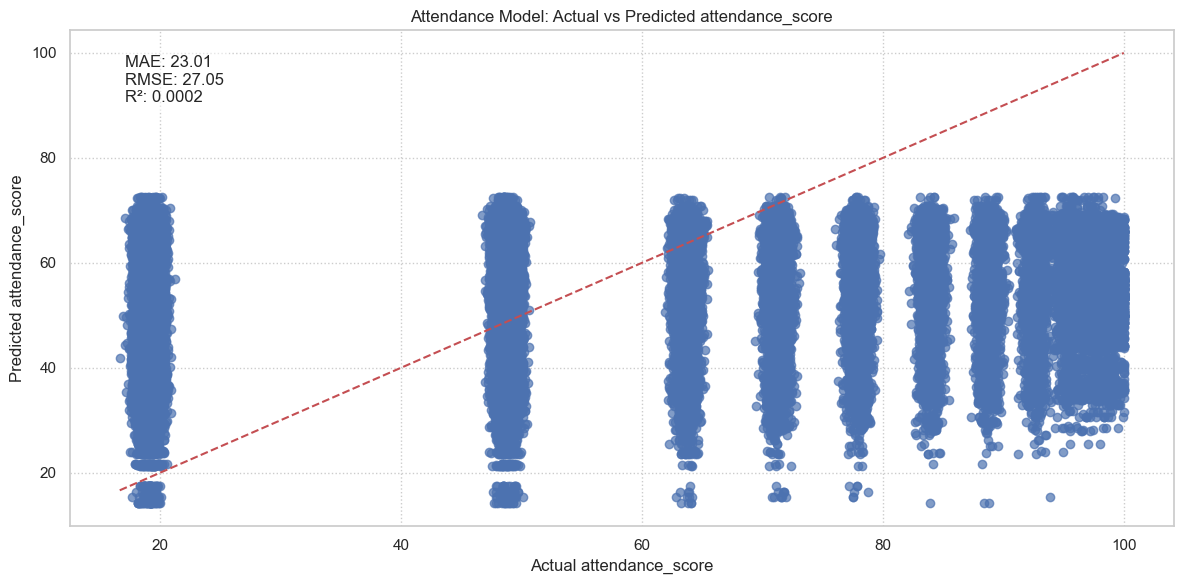

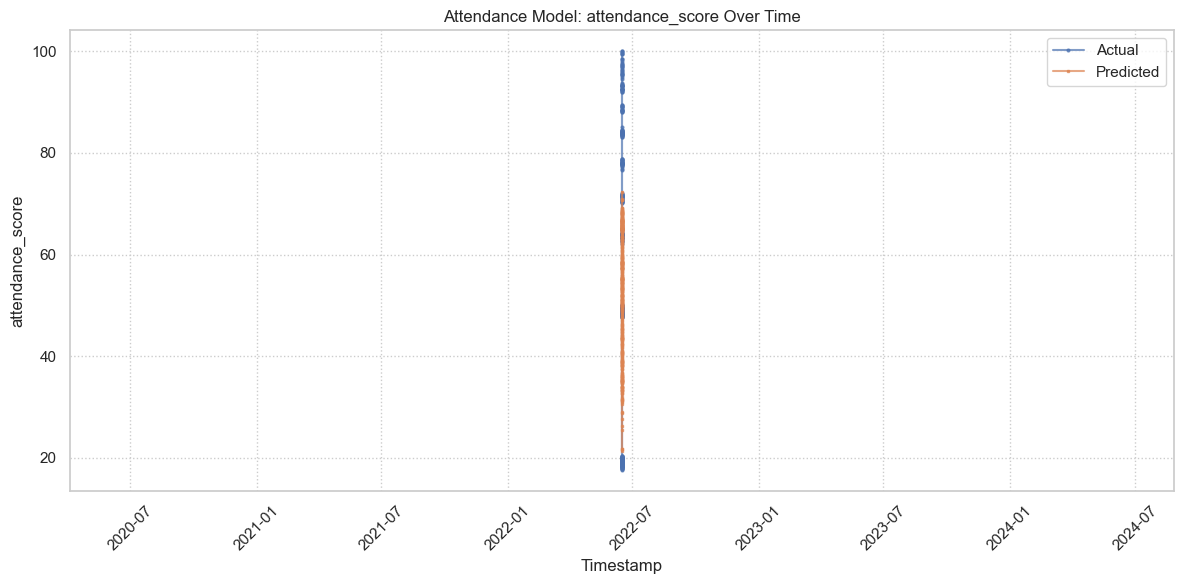

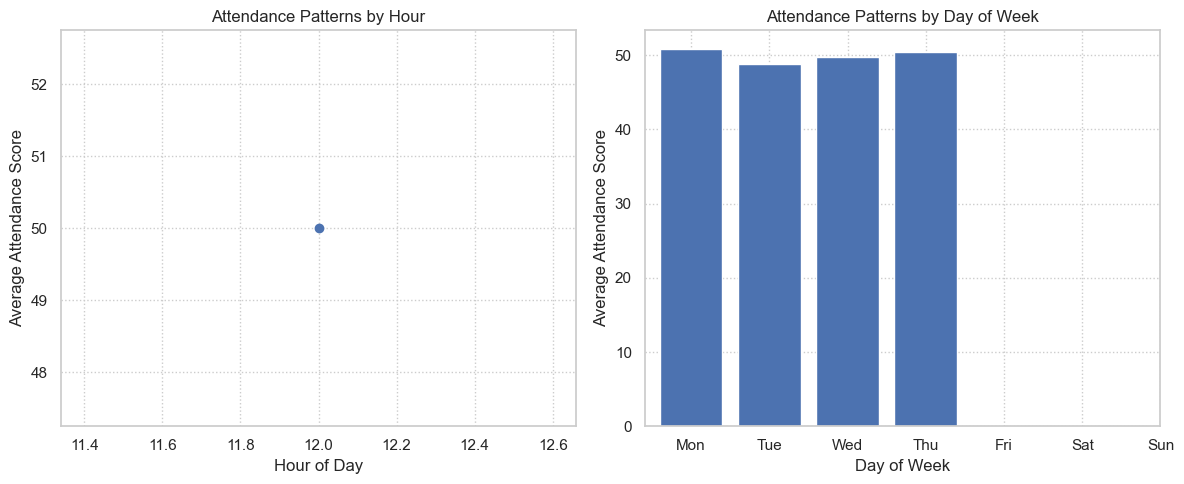


Top 5 highest attendance hours (actual):
  2017-06-15 12:00:00: Score 100, Wait Time 55.0min
  2017-06-15 12:00:00: Score 100, Wait Time 65.0min
  2017-06-15 12:00:00: Score 100, Wait Time 80.0min
  2017-06-15 12:00:00: Score 100, Wait Time 60.0min
  2017-06-15 12:00:00: Score 100, Wait Time 60.0min

Top 5 lowest attendance hours (actual):
  2022-06-15 12:00:00: Score 17, Wait Time 0.0min
  2017-06-15 12:00:00: Score 17, Wait Time 0.0min
  2017-06-15 12:00:00: Score 17, Wait Time 0.0min
  2018-06-15 12:00:00: Score 17, Wait Time 0.0min
  2018-06-15 12:00:00: Score 17, Wait Time 0.0min

5. Predicting attendance for test timestamps...
Generated attendance predictions for 1 test timestamps
Test attendance range: 36.5 - 36.5
Generated attendance predictions for 4 training timestamps

6. Preparing features for wait time prediction...
Found attendance_score column with 503191 valid values
NaN values found: 160686
Selected 66 features: ['closed', 'temperature', 'rain', 'wind', 'is_german_hol

In [29]:
# Execute the main function
results = main()